<a href="https://colab.research.google.com/github/Sai0472003/PatentLitigation_Impact/blob/main/Data_Cleaning2(FJC).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Causal effect of Patent Litigation Outcomes on Firm Financials


In [2174]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2175]:
JFC_1988_Present = pd.read_csv('/content/drive/MyDrive/ECO225_Final_Project/PART1/Civil_1988_to_Present.txt', sep='\t', encoding='latin1')

<ipython-input-2175-caae5146eea8>:1: DtypeWarning: Columns (1,2,9,10,11,13,19,20,23,24,26,38,39,40,41,43,44) have mixed types. Specify dtype option on import or set low_memory=False.
  JFC_1988_Present = pd.read_csv('/content/drive/MyDrive/ECO225_Final_Project/PART1/Civil_1988_to_Present.txt', sep='\t', encoding='latin1')


In [2176]:
cases = pd.read_csv('/content/drive/MyDrive/ECO225_Final_Project/PART1/cases.csv')
cases = cases[['case_row_id', 'case_number', 'case_name', 'case_cause', 'date_filed', 'date_closed', 'jurisdictional_basis']]

In [2177]:
#ISOLATING PANTENT AND TRADENARK INFRINGEMENT SUITES, AND ONLY ORIGINAL PROCEEDINGS
Patents_1988_forwards = pd.DataFrame(JFC_1988_Present[JFC_1988_Present['NOS'].isin([830, 840])]) #only patent/trademark cases
#Patents_1988_forwards  = Patents_1988_forwards[Patents_1988_forwards ['ORIGIN'] == 1] #only original filings
#Patents_1988_forwards  = Patents_1988_forwards[Patents_1988_forwards ['ARBIT'].astype(str) == '-8'] #no formal arbitration courts

clean_JFC_patents = Patents_1988_forwards.copy()

#removing columns that aren't relavent or mostly empty
clean_JFC_patents.drop(columns=['ORIGIN','TITL', 'SECTION', 'SUBSECT', 'ARBIT',
                                'FILEJUDG', 'FILEMAG', 'MDLDOCK',  'TRANSDAT',
                                'TRANSOFF', 'TRANSDOC', 'TRANSORG', 'TDATEUSE',
                                'TRCLACT', 'TERMJUDG', 'TERMMAG', 'DJOINED',
                                'PRETRIAL', 'TRIBEGAN', 'TRIALEND', 'AMTREC',
                                'TRMARB', 'RESIDENC', 'PROSE', 'IFP', 'TAPEYEAR'],
                                 inplace=True)

In [2178]:
clean_JFC_patents.loc[clean_JFC_patents['CLASSACT'] == -8, 'CLASSACT'] = 0

In [2179]:
clean_JFC_patents['unique_identifier'] = clean_JFC_patents['DOCKET'].astype(str).str[:2] + "-cv-" + clean_JFC_patents['DOCKET'].astype(str).str[2:]
clean_JFC_patents['unique_identifier'] = clean_JFC_patents['JURIS'].astype(str) + "-" + clean_JFC_patents['FILEDATE'].astype(str).str.split("/").str[0] + "/" + clean_JFC_patents['FILEDATE'].astype(str).str.split("/").str[1] + "/" + clean_JFC_patents['unique_identifier'].astype(str)
clean_JFC_patents['unique_identifier'] = clean_JFC_patents['unique_identifier'] + "-" + clean_JFC_patents['TERMDATE'].astype(str)

#creating common unique identifier to match JFC dataset
cases['unique_identifier'] = cases['case_number'].astype(str).str.split(":", n=1).str[-1]
cases['unique_identifier'] = cases['date_filed'].astype(str).str.split("-").str[1] + "/" + cases['date_filed'].astype(str).str.split("-").str[2] + "/" +cases['unique_identifier'].astype(str)

for index, row in cases.iterrows():
    if row['jurisdictional_basis'] == "Federal Question":
        cases.loc[index, 'unique_identifier'] = "3-" + row['unique_identifier']
    elif row['jurisdictional_basis'] == "U.S. Government Plaintiff":
        cases.loc[index, 'unique_identifier'] = "1-" + row['unique_identifier']
    elif row['jurisdictional_basis'] == "U.S. Government Defendant":
        cases.loc[index, 'unique_identifier'] = "2-" + row['unique_identifier']
    elif row['jurisdictional_basis'] == "Diversity":
        cases.loc[index, 'unique_identifier'] = "4-" + row['unique_identifier']

cases['unique_identifier'] = cases['unique_identifier'] + "-" + cases['date_closed'].astype(str).str.split("-").str[1] + "/" + cases['date_closed'].astype(str).str.split("-").str[2] + "/" + cases['date_closed'].astype(str).str.split("-").str[0]

In [2180]:
clean_JFC_patents.drop_duplicates(subset=['unique_identifier'], inplace=True)
clean_JFC_patents['unique_identifier'].nunique() / len(clean_JFC_patents)

1.0

In [2181]:
clean_JFC_patents

,CIRCUIT,DISTRICT,OFFICE,DOCKET,FILEDATE,FDATEUSE,JURIS,NOS,JURY,CLASSACT,DEMANDED,COUNTY,PLT,DEF,TERMDATE,PROCPROG,DISP,NOJ,JUDGMENT,STATUSCD,unique_identifier
42,0,90,1,8203478,12/08/1982,12/01/1982,3,830,-8,0,-8,99999,CHUBB INTEG,NATL BANK WASH,02/10/1988,3,13,-8,-8,NaN,3-12/08/82-cv-03478-02/10/1988
47,0,90,1,8300001,01/03/1983,01/01/1983,3,830,-8,0,-8,88888,NEWMAN,MOSSINGHOFF,02/17/1988,8,9,0,2,NaN,3-01/03/83-cv-00001-02/17/1988
188,0,90,1,8403233,10/22/1984,10/01/1984,3,830,-8,0,150,88888,CORP.COMMUNICATIONS,CAPITOL,06/01/1988,2,0,-8,-8,NaN,3-10/22/84-cv-03233-06/01/1988
241,0,90,1,8403720,12/06/1984,12/01/1984,3,840,-8,0,-8,11001,WASH CHIROPTC HLTH,CHIROPTC INC,10/01/1987,3,3,-8,-8,NaN,3-12/06/84-cv-03720-10/01/1987
269,0,90,1,8500006,05/22/1985,05/01/1985,3,830,-8,0,-8,0,FOUR PILLARS ENTP CO,CHANG ETAL,06/01/1988,4,6,0,2,NaN,3-05/22/85-cv-00006-06/01/1988
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10445328,11,3J,4,2100368,12/31/2021,12/01/2021,3,830,P,0,0,13051,"FACTORY DIRECT WHOLESALE, LLC","OFFICE KICK, INC., ET AL",01/01/1900,-8,-8,-8,-8,S,3-12/31/21-cv-00368-01/01/1900
10445345,11,3J,4,2200291,12/12/2022,12/01/2022,3,840,B,0,0,13051,"CRESTWOOD MANAGEMENT, L, ET AL","FERGUSON, ET AL",01/01/1900,-8,-8,-8,-8,S,3-12/12/22-cv-00291-01/01/1900
10445359,11,3J,4,2300115,05/01/2023,05/01/2023,3,840,B,0,0,13051,"VPR BRANDS, LP","VAPE LOFT ABERCORN, LLC, ET AL",01/01/1900,-8,-8,-8,-8,S,3-05/01/23-cv-00115-01/01/1900
10445495,11,3J,4,2400155,07/22/2024,07/01/2024,3,840,P,0,0,13051,"TACMED SOLUTIONS, LLC","ROGUE RANGER, LLC, ET AL",10/23/2024,4,5,0,4,L,3-07/22/24-cv-00155-10/23/2024


In [2182]:
cases.groupby('case_number')['unique_identifier'].nunique().value_counts()
#seems to be errors with mulitple filing/closing dates within the df
#this causes there to be more than one unique_identifiers within a given case

,count
unique_identifier,
1,83411
2,5096
0,1607
3,453
4,33
5,3


In [2183]:
# Identify case_number values that have exactly 1 unique_identifier
valid_cases = cases.groupby('case_number')['unique_identifier'].nunique()
valid_cases = valid_cases[valid_cases == 1].index  # Keep only case_number values with exactly 1 unique_identifier

# Filter the dataframe to retain only those case_number values
cases = cases[cases['case_number'].isin(valid_cases)]
cases.groupby('case_number')['unique_identifier'].nunique().value_counts()

,count
unique_identifier,
1,83411


In [2184]:
cases_JFC = pd.merge(cases, clean_JFC_patents, on='unique_identifier', how='inner')
cases_JFC.groupby('case_number')['unique_identifier'].nunique().value_counts()

,count
unique_identifier,
1,54022


In [2185]:
# Identify case_number values that appear more than once
duplicate_cases = cases_JFC['case_number'].value_counts()
duplicate_cases = duplicate_cases[duplicate_cases > 1].index  # Get case_number values that appear more than once

# Drop rows where case_number is in the duplicate list
cases_JFC = cases_JFC[~cases_JFC['case_number'].isin(duplicate_cases)]

In [2186]:
cases_JFC.drop_duplicates(subset=['unique_identifier'], inplace=True)

<ipython-input-2186-d9526e45a54f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cases_JFC.drop_duplicates(subset=['unique_identifier'], inplace=True)


In [2187]:
pd.set_option('display.max_columns', None)
cases_JFC.head()

,case_row_id,case_number,case_name,case_cause,date_filed,date_closed,jurisdictional_basis,unique_identifier,CIRCUIT,DISTRICT,OFFICE,DOCKET,FILEDATE,FDATEUSE,JURIS,NOS,JURY,CLASSACT,DEMANDED,COUNTY,PLT,DEF,TERMDATE,PROCPROG,DISP,NOJ,JUDGMENT,STATUSCD
0,6908.0,1:98-cv-00596,Mettke v. Touchnet Information,35:183 Patent Infringement,1998-03-16,1998-09-21,Federal Question,3-03/16/98-cv-00596-09/21/1998,11,26,1,9800596,03/16/1998,03/01/1998,3,830,-8,0,0,1015,METTKE,TOUCHNET INFORMATION,09/21/1998,3,14,-8,-8,NaN
1,6933.0,1:98-cv-00654,"Monsanto Co. Inc. v. Styron, et al",28:1338 Patent Infringement,1998-06-29,1999-03-15,Federal Question,3-06/29/98-cv-00654-03/15/1999,11,28,1,9800654,06/29/1998,06/01/1998,3,830,-8,0,0,1097,MONSANTO CO. INC.,"STYRON, ET AL",03/15/1999,10,13,-8,-8,NaN
2,86730.0,1:18-cv-00012,Sundesa LLC v. Eurark LLC,35:271 Patent Infringement,2018-02-13,2018-07-06,Federal Question,3-02/13/18-cv-00012-07/06/2018,8,60,1,1800012,02/13/2018,02/01/2018,3,830,B,0,0,88888,SUNDESA LLC,EURARK LLC,07/06/2018,3,13,0,0,L
3,30787.0,2:99-cv-00674,"Star Video Duplictns v. US Magnetics Corp, et al",15:1125 Trademark Infringement (Lanham Act),1999-04-09,1999-12-16,Federal Question,3-04/09/99-cv-00674-12/16/1999,9,70,2,9900674,04/09/1999,04/01/1999,3,830,-8,0,0,4013,STAR VIDEO DUPLICTNS,"US MAGNETICS CORP, ET AL",12/16/1999,10,13,-8,-8,NaN
4,30985.0,2:99-cv-02348,"Brother Industries v. Jing Mold Enterprise, et al",28:1338 Patent Infringement,1999-03-05,2001-03-13,Federal Question,3-03/05/99-cv-02348-03/13/2001,9,73,2,9902348,03/05/1999,03/01/1999,3,830,-8,0,0,99999,BROTHER INDUSTRIES,"JING MOLD ENTERPRISE, ET AL",03/13/2001,3,13,-8,-8,L


In [2188]:
clean_cases_JFC = cases_JFC.copy()
clean_cases_JFC.drop(columns=['unique_identifier', 'DOCKET', 'FILEDATE',
                               'FDATEUSE', 'TERMDATE', 'STATUSCD'])

,case_row_id,case_number,case_name,case_cause,date_filed,date_closed,jurisdictional_basis,CIRCUIT,DISTRICT,OFFICE,JURIS,NOS,JURY,CLASSACT,DEMANDED,COUNTY,PLT,DEF,PROCPROG,DISP,NOJ,JUDGMENT
0,6908.0,1:98-cv-00596,Mettke v. Touchnet Information,35:183 Patent Infringement,1998-03-16,1998-09-21,Federal Question,11,26,1,3,830,-8,0,0,1015,METTKE,TOUCHNET INFORMATION,3,14,-8,-8
1,6933.0,1:98-cv-00654,"Monsanto Co. Inc. v. Styron, et al",28:1338 Patent Infringement,1998-06-29,1999-03-15,Federal Question,11,28,1,3,830,-8,0,0,1097,MONSANTO CO. INC.,"STYRON, ET AL",10,13,-8,-8
2,86730.0,1:18-cv-00012,Sundesa LLC v. Eurark LLC,35:271 Patent Infringement,2018-02-13,2018-07-06,Federal Question,8,60,1,3,830,B,0,0,88888,SUNDESA LLC,EURARK LLC,3,13,0,0
3,30787.0,2:99-cv-00674,"Star Video Duplictns v. US Magnetics Corp, et al",15:1125 Trademark Infringement (Lanham Act),1999-04-09,1999-12-16,Federal Question,9,70,2,3,830,-8,0,0,4013,STAR VIDEO DUPLICTNS,"US MAGNETICS CORP, ET AL",10,13,-8,-8
4,30985.0,2:99-cv-02348,"Brother Industries v. Jing Mold Enterprise, et al",28:1338 Patent Infringement,1999-03-05,2001-03-13,Federal Question,9,73,2,3,830,-8,0,0,99999,BROTHER INDUSTRIES,"JING MOLD ENTERPRISE, ET AL",3,13,-8,-8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54028,30718.0,2:99-cv-00216,"Impact Roller Tech, et al v. Star Aggregates Inc",28:1338 Patent Infringement,1999-10-06,2000-03-28,Federal Question,10,89,2,3,830,-8,0,0,88888,"IMPACT ROLLER TECH, ET AL",STAR AGGREGATES INC,5,5,0,1
54029,28107.0,2:93-cv-00004,Construction Tech v. Heating,35:271 Patent Infringement,1993-01-04,1993-08-11,Federal Question,10,89,2,3,830,-8,0,0,88888,CONSTRUCTION TECH,HEATING,3,12,-8,-8
54030,28883.0,2:95-cv-00217,Wyoming Woolens v. Acorn Products Co,28:1338 Patent Infringement,1995-09-29,1995-10-06,Federal Question,10,89,2,3,830,-8,0,0,56039,WYOMING WOOLENS,ACORN PRODUCTS CO,1,12,-8,-8
54031,29713.0,2:97-cv-00019,Chey Land & Cattle v. Crown Cork & Seal Co,35:271 Patent Infringement,1997-01-24,1997-07-25,Federal Question,10,89,2,3,830,-8,0,2000,56021,CHEY LAND & CATTLE,CROWN CORK & SEAL CO,1,12,-8,-8


# ***Querying and Merging Data on Company Financials from WRDS***

In [2189]:
!pip install wrds
import wrds
db = wrds.Connection(wrds_username="sai047")

Loading library list...
Done


In [2190]:
query = """
SELECT gvkey, conm
FROM comp.company
"""
comp_names = db.raw_sql(query)

In [2191]:
comp_names

,gvkey,conm
0,001000,A & E PLASTIK PAK INC
1,001001,A & M FOOD SERVICES INC
2,001002,AAI CORP
3,001003,A.A. IMPORTING CO INC
4,001004,AAR CORP
...,...,...
55020,356128,JOINT STOCK COMPANY KASPI KZ
55021,356289,SOLARBANK CORP
55022,356687,ATHA ENERGY CORP
55023,356859,ACUREN CORP


In [2192]:
gvkey_plt = pd.DataFrame(clean_cases_JFC[['PLT']])
gvkey_def = pd.DataFrame(clean_cases_JFC[['DEF']])

In [2193]:
def clean_names(name):
    name = name.replace(",", '')  # Remove Commas
    name = name.replace(".", "")  # Remove periods
    name = name.replace("ET AL", "").strip()  # Remove 'ET AL' (case insensitive if already upper)
    return name

gvkey_def = pd.DataFrame(gvkey_def['DEF'].apply(clean_names)) # Apply to the 'DEF' column
gvkey_plt = pd.DataFrame(gvkey_plt['PLT'].apply(clean_names)) # Apply to the 'PLT' column
comp_names['conm'].apply(clean_names)
clean_cases_JFC['PLT'] = clean_cases_JFC['PLT'].apply(clean_names)
clean_cases_JFC['DEF'] = clean_cases_JFC['DEF'].apply(clean_names)

In [2194]:
comp_names['name'] = comp_names['conm']
comp_names.drop(columns=['conm'], inplace=True)
gvkey_plt['name'] = gvkey_plt['PLT']
gvkey_def['name'] = gvkey_def['DEF']

In [2195]:
gvkey_def = gvkey_def.merge(comp_names, on='name', how='inner')
gvkey_def.drop(columns=['name'], inplace=True)

gvkey_plt = gvkey_plt.merge(comp_names, on='name', how='inner')
gvkey_plt.drop(columns=['name'], inplace=True)

In [2196]:
gvkey_def

,DEF,gvkey
0,INTERMEDICS INC,006045
1,TEXAS INSTRUMENTS INC,010499
2,ENCORE COMPUTER CORP,004344
3,EBAY INC,114524
4,LEGGETT & PLATT INC,006649
...,...,...
5921,OEC MEDICAL SYSTEMS INC,003935
5922,CRAY INC,061350
5923,CISCO SYSTEMS INC,020779
5924,HUBBELL INC,005764


In [2197]:
gvkey_plt

,PLT,gvkey
0,KIDDE INC,006430
1,SONOCO PRODUCTS CO,009815
2,DCL INC,003688
3,INTERGRAPH CORP,006036
4,ALABAMA POWER CO,001225
...,...,...
2610,GILEAD SCIENCES INC,024856
2611,PFIZER INC,008530
2612,JAPAN TOBACCO INC,223528
2613,PFIZER INC,008530


In [2198]:
plaintiff_RnD = pd.merge(clean_cases_JFC[['case_row_id', 'case_number', 'date_filed',
                                 'date_closed', 'PLT']], gvkey_plt, on='PLT',
                                  how='inner')
plaintiff_RnD['case_number'].nunique()
plaintiff_RnD.drop_duplicates(inplace=True)

In [2199]:
plaintiff_RnD

,case_row_id,case_number,date_filed,date_closed,PLT,gvkey
0,58881.0,4:85-cv-00399,1985-04-25,1989-10-23,KIDDE INC,006430
1,59800.0,4:96-cv-02682,1996-09-03,1999-02-23,SONOCO PRODUCTS CO,009815
6,7660.0,1:99-cv-01028,1999-04-26,1999-06-08,DCL INC,003688
7,64094.0,5:97-cv-03023,1997-11-17,2002-05-06,INTERGRAPH CORP,006036
8,30252.0,2:98-cv-00323,1998-02-11,1998-06-10,ALABAMA POWER CO,001225
...,...,...,...,...,...,...
52945,25530.0,1:15-cv-00149,2015-08-31,2015-11-02,GILEAD SCIENCES INC,024856
52970,98842.0,1:19-cv-00097,2019-04-29,2019-10-03,PFIZER INC,008530
53042,98446.0,1:19-cv-00012,2019-01-24,2019-05-09,JAPAN TOBACCO INC,223528
53044,91470.0,1:20-cv-00244,2020-10-16,2021-06-09,PFIZER INC,008530


In [2200]:
defendent_RnD = pd.merge(clean_cases_JFC[['case_row_id', 'case_number', 'date_filed',
                                 'date_closed', 'DEF']], gvkey_def, on='DEF',
                                  how='inner')

defendent_RnD['case_number'].nunique()
defendent_RnD.drop_duplicates(inplace=True)

In [2201]:
defendent_RnD

,case_row_id,case_number,date_filed,date_closed,DEF,gvkey
0,59316.0,4:93-cv-00626,1993-06-25,1996-10-08,INTERMEDICS INC,006045
5,78121.0,2:11-cv-01037,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,010499
25,78037.0,5:92-cv-02573,1992-11-02,1996-07-29,ENCORE COMPUTER CORP,004344
26,26100.0,1:15-cv-01059,2015-06-24,2017-05-15,EBAY INC,114524
68,66037.0,5:11-cv-01349,2011-04-20,2012-09-17,LEGGETT & PLATT INC,006649
...,...,...,...,...,...,...
196991,50230.0,3:97-cv-00860,1997-12-18,1998-03-12,OEC MEDICAL SYSTEMS INC,003935
196992,90118.0,3:18-cv-00318,2018-05-02,2019-04-24,CRAY INC,061350
196996,50940.0,3:99-cv-00782,1999-12-10,2000-03-23,CISCO SYSTEMS INC,020779
197094,67177.0,6:99-cv-00342,1999-05-03,2001-01-19,HUBBELL INC,005764


In [2202]:
set1 = set(defendent_RnD['case_number'].unique())
set2 = set(plaintiff_RnD['case_number'].unique())
common_elements = set1.intersection(set2)

print("The number of unique cases with known gvkeys:",
      len(set1) + len(set2) - len(common_elements))

The number of unique cases with known gvkeys: 8248


In [2203]:
# Convert all relevant date columns to datetime format
plaintiff_RnD["date_filed"] = pd.to_datetime(plaintiff_RnD["date_filed"])
plaintiff_RnD["date_closed"] = pd.to_datetime(plaintiff_RnD["date_closed"])
defendent_RnD["date_filed"] = pd.to_datetime(defendent_RnD["date_filed"])
defendent_RnD["date_closed"] = pd.to_datetime(defendent_RnD["date_closed"])

In [2204]:
# Get all GVKEYs involved in lawsuits
gvkeys = list(set(list(plaintiff_RnD["gvkey"]) + list(defendent_RnD["gvkey"])))

from pandas.tseries.offsets import DateOffset

# Extend date range by 4 quarters (1 year)
min_date = min(plaintiff_RnD["date_filed"].min(), defendent_RnD["date_filed"].min()) - DateOffset(years=1)
max_date = max(plaintiff_RnD["date_closed"].max(), defendent_RnD["date_closed"].max()) + DateOffset(years=1)

print(f"Querying R&D data from {min_date.date()} to {max_date.date()}")
print(f"Querying financials for {len(gvkeys)} firms from {min_date} to {max_date}")

Querying R&D data from 1975-04-26 to 2023-10-27
Querying financials for 2141 firms from 1975-04-26 00:00:00 to 2023-10-27 00:00:00


In [2205]:
query = f"""
SELECT gvkey, qdate, rd_sale
FROM wrdsapps_finratio.firm_ratio
WHERE gvkey IN ({",".join("'" + str(g) + "'" for g in gvkeys)})
AND qdate BETWEEN '{min_date}' AND '{max_date}'
AND rd_sale IS NOT NULL
"""
rd_sale_data = db.raw_sql(query)
rd_sale_data.drop_duplicates()

query = f"""
SELECT gvkey, qdate, npm
FROM wrdsapps_finratio.firm_ratio
WHERE gvkey IN ({",".join("'" + str(g) + "'" for g in gvkeys)})
AND qdate BETWEEN '{min_date}' AND '{max_date}'
AND rd_sale IS NOT NULL
"""
npm_data = db.raw_sql(query)
npm_data.drop_duplicates()


,gvkey,qdate,npm
0,001013,1982-01-31,0.057593
3,001013,1982-04-30,0.057593
6,001013,1982-07-31,0.057593
9,001013,1982-10-31,0.05467
12,001013,1983-01-31,0.057206
...,...,...,...
377757,347007,2022-09-30,-717.43447
377760,347007,2022-12-31,-1735.695833
377763,347007,2023-03-31,-733.931741
377766,347007,2023-06-30,-799.619932


In [2206]:
rd_sale_data

,gvkey,qdate,rd_sale
0,001013,1982-01-31,0.079463
1,001013,1982-01-31,0.079463
2,001013,1982-01-31,0.079463
3,001013,1982-04-30,0.079463
4,001013,1982-04-30,0.079463
...,...,...,...
377766,347007,2023-06-30,442.771959
377767,347007,2023-06-30,442.771959
377768,347007,2023-06-30,442.771959
377769,347007,2023-09-30,429.696043


In [2207]:
npm_data

,gvkey,qdate,npm
0,001013,1982-01-31,0.057593
1,001013,1982-01-31,0.057593
2,001013,1982-01-31,0.057593
3,001013,1982-04-30,0.057593
4,001013,1982-04-30,0.057593
...,...,...,...
377766,347007,2023-06-30,-799.619932
377767,347007,2023-06-30,-799.619932
377768,347007,2023-06-30,-799.619932
377769,347007,2023-09-30,-823.77518


In [2208]:
# Convert date_filed and date_closed to their respective quarter-end dates
plaintiff_RnD["filing_quarter"] = plaintiff_RnD["date_filed"] + pd.offsets.QuarterEnd(0)
plaintiff_RnD["closing_quarter"] = plaintiff_RnD["date_closed"] + pd.offsets.QuarterEnd(0)

defendent_RnD["filing_quarter"] = defendent_RnD["date_filed"] + pd.offsets.QuarterEnd(0)
defendent_RnD["closing_quarter"] = defendent_RnD["date_closed"] + pd.offsets.QuarterEnd(0)

rd_sale_data["qdate"] = pd.to_datetime(rd_sale_data["qdate"])
npm_data["qdate"] = pd.to_datetime(npm_data["qdate"])

In [2209]:
# Merge npm for the quarter of case filing
plaintiff_npm = plaintiff_RnD.merge(npm_data, left_on=["gvkey", "filing_quarter"], right_on=["gvkey", "qdate"], how="left"
    ).rename(columns={"npm": "filing_npm"}).drop(columns=["qdate"])

defendent_npm = defendent_RnD.merge(
    npm_data, left_on=["gvkey", "filing_quarter"], right_on=["gvkey", "qdate"], how="left" # Changed rd_sale_data to npm_data
    ).rename(columns={"npm": "filing_npm"}).drop(columns=["qdate"])

# Merge npm for the quarter of case closing
plaintiff_npm = plaintiff_npm.merge(npm_data, left_on=["gvkey", "closing_quarter"], right_on=["gvkey", "qdate"], how="left"
    ).rename(columns={"npm": "closing_npm"}).drop(columns=["qdate"])

defendent_npm = defendent_npm.merge(
    npm_data, left_on=["gvkey", "closing_quarter"], right_on=["gvkey", "qdate"], how="left" # Changed rd_sale_data to npm_data
    ).rename(columns={"npm": "closing_npm"}).drop(columns=["qdate"])

plaintiff_npm.drop_duplicates(inplace=True)
defendent_npm.drop_duplicates(inplace=True)

plaintiff_npm.dropna(subset=['filing_npm', 'closing_npm'], inplace=True)
defendent_npm.dropna(subset=['filing_npm', 'closing_npm'], inplace=True)

In [2210]:
# Merge R&D ratios for the quarter of case filing
plaintiff_RnD = plaintiff_RnD.merge(
    rd_sale_data, left_on=["gvkey", "filing_quarter"], right_on=["gvkey", "qdate"], how="left"
).rename(columns={"rd_sale": "filing_rd_sale"}).drop(columns=["qdate"])

defendent_RnD = defendent_RnD.merge(
    rd_sale_data, left_on=["gvkey", "filing_quarter"], right_on=["gvkey", "qdate"], how="left"
).rename(columns={"rd_sale": "filing_rd_sale"}).drop(columns=["qdate"])

# Merge R&D ratios for the quarter of case closing
plaintiff_RnD = plaintiff_RnD.merge(
    rd_sale_data, left_on=["gvkey", "closing_quarter"], right_on=["gvkey", "qdate"], how="left"
).rename(columns={"rd_sale": "closing_rd_sale"}).drop(columns=["qdate"])

defendent_RnD = defendent_RnD.merge(
    rd_sale_data, left_on=["gvkey", "closing_quarter"], right_on=["gvkey", "qdate"], how="left"
).rename(columns={"rd_sale": "closing_rd_sale"}).drop(columns=["qdate"])


plaintiff_RnD.drop_duplicates(inplace=True)
defendent_RnD.drop_duplicates(inplace=True)

plaintiff_RnD.dropna(subset=['filing_rd_sale', 'closing_rd_sale'], inplace=True)
defendent_RnD.dropna(subset=['filing_rd_sale', 'closing_rd_sale'], inplace=True)

In [2211]:
defendent_npm

,case_row_id,case_number,date_filed,date_closed,DEF,gvkey,filing_quarter,closing_quarter,filing_npm,closing_npm
1,78121.0,2:11-cv-01037,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,010499,2011-12-31,2015-03-31,0.163247,0.226309
13,26100.0,1:15-cv-01059,2015-06-24,2017-05-15,EBAY INC,114524,2015-06-30,2017-06-30,0.24491,0.796015
22,66037.0,5:11-cv-01349,2011-04-20,2012-09-17,LEGGETT & PLATT INC,006649,2011-06-30,2012-09-30,0.051063,0.047465
31,78036.0,2:87-cv-00979,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,010735,1987-06-30,1989-09-30,0.010817,0.037153
43,77089.0,1:17-cv-00179,2017-04-25,2017-09-21,APPLE INC,001690,2017-06-30,2017-09-30,0.208723,0.210924
...,...,...,...,...,...,...,...,...,...,...
30334,58458.0,3:15-cv-00621,2015-09-25,2022-05-11,APPLE INC,001690,2015-09-30,2022-06-30,0.228458,0.25709
30343,55972.0,3:11-cv-00709,2011-10-17,2012-03-22,AVID TECHNOLOGY INC,027925,2011-12-31,2012-03-31,-0.035093,-0.009664
30353,50230.0,3:97-cv-00860,1997-12-18,1998-03-12,OEC MEDICAL SYSTEMS INC,003935,1997-12-31,1998-03-31,0.078352,0.079669
30362,90118.0,3:18-cv-00318,2018-05-02,2019-04-24,CRAY INC,061350,2018-06-30,2019-06-30,-0.322168,-0.271706


In [2212]:
defendent_RnD

,case_row_id,case_number,date_filed,date_closed,DEF,gvkey,filing_quarter,closing_quarter,filing_rd_sale,closing_rd_sale
1,78121.0,2:11-cv-01037,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,010499,2011-12-31,2015-03-31,0.12521,0.100666
13,26100.0,1:15-cv-01059,2015-06-24,2017-05-15,EBAY INC,114524,2015-06-30,2017-06-30,0.108168,0.125455
22,66037.0,5:11-cv-01349,2011-04-20,2012-09-17,LEGGETT & PLATT INC,006649,2011-06-30,2012-09-30,0.0,0.0
31,78036.0,2:87-cv-00979,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,010735,1987-06-30,1989-09-30,0.0,0.0
43,77089.0,1:17-cv-00179,2017-04-25,2017-09-21,APPLE INC,001690,2017-06-30,2017-09-30,0.049904,0.05052
...,...,...,...,...,...,...,...,...,...,...
30334,58458.0,3:15-cv-00621,2015-09-25,2022-05-11,APPLE INC,001690,2015-09-30,2022-06-30,0.034516,0.065185
30343,55972.0,3:11-cv-00709,2011-10-17,2012-03-22,AVID TECHNOLOGY INC,027925,2011-12-31,2012-03-31,0.174217,0.170799
30353,50230.0,3:97-cv-00860,1997-12-18,1998-03-12,OEC MEDICAL SYSTEMS INC,003935,1997-12-31,1998-03-31,0.071796,0.070088
30362,90118.0,3:18-cv-00318,2018-05-02,2019-04-24,CRAY INC,061350,2018-06-30,2019-06-30,0.242269,0.325071


In [2213]:
defendent_RnD[defendent_RnD['filing_rd_sale'] == defendent_RnD['closing_rd_sale']]

,case_row_id,case_number,date_filed,date_closed,DEF,gvkey,filing_quarter,closing_quarter,filing_rd_sale,closing_rd_sale
22,66037.0,5:11-cv-01349,2011-04-20,2012-09-17,LEGGETT & PLATT INC,006649,2011-06-30,2012-09-30,0.0,0.0
31,78036.0,2:87-cv-00979,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,010735,1987-06-30,1989-09-30,0.0,0.0
64,62459.0,4:11-cv-00454,2011-06-01,2013-08-23,CEC ENTERTAINMENT INC,015092,2011-06-30,2013-09-30,0.0,0.0
114,30951.0,2:99-cv-02009,1999-11-12,2001-01-11,SKYMALL INC,064127,1999-12-31,2001-03-31,0.0,0.0
212,39374.0,2:10-cv-03801,2010-05-20,2010-05-20,AT&T INC,009899,2010-06-30,2010-06-30,0.008031,0.008031
...,...,...,...,...,...,...,...,...,...,...
30098,43307.0,2:13-cv-01655,2013-09-12,2014-01-17,BLYTH INC,030219,2013-09-30,2014-03-31,0.0,0.0
30114,28157.0,2:93-cv-00423,1993-04-27,1993-12-03,ELJER INDUSTRIES INC,015233,1993-06-30,1993-12-31,0.0,0.0
30125,29362.0,2:96-cv-00490,1996-04-23,1998-07-20,SUNBEAM CORPORATION,001278,1996-06-30,1998-09-30,0.0,0.0
30269,55854.0,3:11-cv-00232,2011-03-30,2012-03-27,LEGGETT & PLATT INC,006649,2011-03-31,2012-03-31,0.0,0.0


In [2214]:
set1 = set(defendent_RnD['case_number'].unique())
set2 = set(plaintiff_RnD['case_number'].unique())
common_elements = set1.intersection(set2)

print("The number of unique cases with known gvkeys:",
      len(set1) + len(set2) - len(common_elements))

The number of unique cases with known gvkeys: 4286


In [2215]:
defendent_RnD.to_csv("defendent_RnD.csv", index=False)
plaintiff_RnD.to_csv("plaintiff_RnD.csv", index=False)

from google.colab import files
files.download("defendent_RnD.csv")
files.download("plaintiff_RnD.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [2216]:
#getting company industry and sector classifcations/location variables
query = """
SELECT gvkey, gsector, naics, loc, spcsrc, state
FROM comp.company
"""
company_info = db.raw_sql(query)

In [2217]:
# Rename columns to more descriptive names
company_info.rename(columns={
    "gsector": "gics_sector",
    "naics": "naics_code",
    "loc": "company_loc",
    "spcsrc": "sp_quality_ranking",
    "state": "state_province"
}, inplace=True)

company_info.drop_duplicates(inplace=True)
company_info

,gvkey,gics_sector,naics_code,company_loc,sp_quality_ranking,state_province
0,001000,<NA>,<NA>,USA,<NA>,<NA>
1,001001,25,722,USA,<NA>,OK
2,001002,<NA>,<NA>,USA,<NA>,MD
3,001003,25,442110,USA,<NA>,MO
4,001004,20,423860,USA,B,IL
...,...,...,...,...,...,...
55020,356128,40,522291,KAZ,<NA>,<NA>
55021,356289,20,2371,CAN,<NA>,ON
55022,356687,10,212290,CAN,<NA>,BC
55023,356859,20,541380,USA,<NA>,TX


In [2218]:
#mering in the company info data
plaintiff_RnD = plaintiff_RnD.merge(company_info, on='gvkey', how='left')
defendent_RnD = defendent_RnD.merge(company_info, on='gvkey', how='left')

plaintiff_npm = plaintiff_npm.merge(company_info, on='gvkey', how='left')
defendent_npm = defendent_npm.merge(company_info, on='gvkey', how='left')

# ***Cleaning up Case Outcomes***

In [2219]:
clean_cases_JFC.columns

Index(['case_row_id', 'case_number', 'case_name', 'case_cause', 'date_filed',
       'date_closed', 'jurisdictional_basis', 'unique_identifier', 'CIRCUIT',
       'DISTRICT', 'OFFICE', 'DOCKET', 'FILEDATE', 'FDATEUSE', 'JURIS', 'NOS',
       'JURY', 'CLASSACT', 'DEMANDED', 'COUNTY', 'PLT', 'DEF', 'TERMDATE',
       'PROCPROG', 'DISP', 'NOJ', 'JUDGMENT', 'STATUSCD'],
      dtype='object')

In [2220]:
#crearing dummy for disposal before issue joined (case if disposed without any court proceedings)
clean_cases_JFC['disp_before_issue_joined'] = 0
clean_cases_JFC.loc[clean_cases_JFC['PROCPROG'].isin([1, 2, 11, 12]), 'disp_before_issue_joined'] = 1
clean_cases_JFC = clean_cases_JFC.drop(columns=['PROCPROG'])

In [2221]:
#dummies for nature of case disposal

#when case is transferred out
clean_cases_JFC['disp_transferred'] = 0
clean_cases_JFC.loc[clean_cases_JFC['DISP'].isin([0,1,10,11]), 'disp_transferred'] = 1

#when cases are dismissed, this includes settlements
clean_cases_JFC['disp_dismissed'] = 0
clean_cases_JFC.loc[clean_cases_JFC['DISP'].isin([2,3,12,13,14]), 'disp_dismissed'] = 1

#specifically cases that were settled or voluntarily dismissed
clean_cases_JFC['disp_settled'] = 0
clean_cases_JFC.loc[clean_cases_JFC['DISP'].isin([13,12]), 'disp_settled'] = 1

#when cases are disposed via judgment
clean_cases_JFC['disp_judgment'] = 0
clean_cases_JFC.loc[clean_cases_JFC['DISP'].isin([4,5,6,7,8,9,15,16,17,18,19,20]), 'disp_judgment'] = 1

clean_cases_JFC = clean_cases_JFC.drop(columns=['DISP'])

In [2222]:
#dummy for whether judgement involves monetary award
clean_cases_JFC['judgment_monetary_award'] = 0
clean_cases_JFC.loc[clean_cases_JFC['NOJ'].isin([1,2]), 'judgment_monetary_award'] = 1
clean_cases_JFC.loc[clean_cases_JFC['disp_judgment'].isin([0]), 'judgment_monetary_award'] = np.nan

#dummy for whether judgment involves an injuction (one of the parties is instructed to stop doing something)
clean_cases_JFC['judgment_injunction'] = 0
clean_cases_JFC.loc[clean_cases_JFC['NOJ'].isin([3]), 'judgment_injunction'] = 1
clean_cases_JFC.loc[clean_cases_JFC['disp_judgment'].isin([0]), 'judgment_injunction'] = np.nan


#dummy for whether judgment involves a cost to be paid by either party (attorney fee or losing property etc.)
clean_cases_JFC['judgment_ordered_loss'] = 0
clean_cases_JFC.loc[clean_cases_JFC['NOJ'].isin([4,5,6]), 'judgment_ordered_loss'] = 1
clean_cases_JFC.loc[clean_cases_JFC['disp_judgment'].isin([0]), 'judgment_ordered_loss'] = np.nan


clean_cases_JFC = clean_cases_JFC.drop(columns=['NOJ'])

In [2223]:
#dummy for whether judgment finds in favour of plaintiff
clean_cases_JFC['judgment_for_plaintiff'] = 0
clean_cases_JFC.loc[clean_cases_JFC['JUDGMENT'].isin([1]), 'judgment_for_plaintiff'] = 1
clean_cases_JFC.loc[clean_cases_JFC['disp_judgment'].isin([0]), 'judgment_for_plaintiff'] = np.nan

#dummy for whether judgment finds in favour of defendent
clean_cases_JFC['judgment_for_defendent'] = 0
clean_cases_JFC.loc[clean_cases_JFC['JUDGMENT'].isin([2]), 'judgment_for_defendent'] = 1
clean_cases_JFC.loc[clean_cases_JFC['disp_judgment'].isin([0]), 'judgment_for_defendent'] = np.nan

#dummy for whether judgment finds in favour of both parties
clean_cases_JFC['judgment_for_both'] = 0
clean_cases_JFC.loc[clean_cases_JFC['JUDGMENT'].isin([3]), 'judgment_for_both'] = 1
clean_cases_JFC.loc[clean_cases_JFC['disp_judgment'].isin([0]), 'judgment_for_both'] = np.nan

clean_cases_JFC = clean_cases_JFC.drop(columns=['JUDGMENT'])

In [2224]:
#adding columns for gvkeys- to link with wrds/compustat/ibes data
clean_cases_JFC = clean_cases_JFC.merge(gvkey_plt, on='PLT', how='left')
clean_cases_JFC = clean_cases_JFC.merge(gvkey_def, on='DEF', how='left')

In [2225]:
clean_cases_JFC.drop_duplicates(inplace=True)
clean_cases_JFC.rename(columns={'gvkey_x': 'gvkey_plt', 'gvkey_y': 'gvkey_def'}, inplace=True)
clean_cases_JFC = clean_cases_JFC.dropna(subset=['gvkey_plt', 'gvkey_def'], how='all')

In [2226]:
#dummy for nature of suit == 830 (patent infringement), reference is 840 trademark infringment
clean_cases_JFC = clean_cases_JFC[clean_cases_JFC['NOS'] == 830]

#only taking cases that have federal question jurisdiction
clean_cases_JFC = clean_cases_JFC[clean_cases_JFC['JURIS'] == 3]

In [2227]:
clean_cases_JFC = clean_cases_JFC.drop(columns=['STATUSCD'])
clean_cases_JFC = clean_cases_JFC.drop(columns=['DEMANDED'])
clean_cases_JFC = clean_cases_JFC.drop(columns=['CLASSACT'])
clean_cases_JFC = clean_cases_JFC.drop(columns=['unique_identifier'])
clean_cases_JFC = clean_cases_JFC.drop(columns=['NOS'])
clean_cases_JFC = clean_cases_JFC.drop(columns=['jurisdictional_basis'])
clean_cases_JFC = clean_cases_JFC.drop(columns=['JURIS'])

In [2228]:
#dummies for which party/parties demand a jury

#plaintiff demands a jury:
clean_cases_JFC['jury_demand_plaintiff'] = np.nan
clean_cases_JFC.loc[clean_cases_JFC['JURY'].astype(str).isin(['P']), 'jury_demand_plaintiff'] = 1
clean_cases_JFC.loc[clean_cases_JFC['JURY'].isin(['B', 'D', 'N']), 'jury_demand_plaintiff'] = 0

#defendant demands a jury
clean_cases_JFC['jury_demand_defendent'] = np.nan
clean_cases_JFC.loc[clean_cases_JFC['JURY'].astype(str).isin(['D']), 'jury_demand_defendent'] = 1
clean_cases_JFC.loc[clean_cases_JFC['JURY'].isin(['B', 'P', 'N']), 'jury_demand_defendent'] = 0


#both parties demand a jury
clean_cases_JFC['jury_demand_both'] = np.nan
clean_cases_JFC.loc[clean_cases_JFC['JURY'].astype(str).isin(['B']), 'jury_demand_both'] = 1
clean_cases_JFC.loc[clean_cases_JFC['JURY'].isin(['P', 'D', 'N']), 'jury_demand_both'] = 0

#dummy for if suit was filed under 35:271 direct patent infringement
clean_cases_JFC['infringement_35_271'] = 0
clean_cases_JFC.loc[clean_cases_JFC['case_cause'].astype(str).isin(['35:271 Patent Infringement']), 'infringement_35_271'] = 1

clean_cases_JFC = clean_cases_JFC.drop(columns=['JURY','FILEDATE', 'FDATEUSE', 'TERMDATE', 'case_cause'])

In [2229]:
clean_cases_JFC

,case_row_id,case_number,case_name,date_filed,date_closed,CIRCUIT,DISTRICT,OFFICE,DOCKET,COUNTY,PLT,DEF,disp_before_issue_joined,disp_transferred,disp_dismissed,disp_settled,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_plaintiff,judgment_for_defendent,judgment_for_both,gvkey_plt,gvkey_def,jury_demand_plaintiff,jury_demand_defendent,jury_demand_both,infringement_35_271
21,59316.0,4:93-cv-00626,"Medtronic, Inc., et al v. Intermedics, Inc., e...",1993-06-25,1996-10-08,8,64,4,9300626,27053,MEDTRONIC INC,INTERMEDICS INC,0,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,006045,NaN,NaN,NaN,0
26,58881.0,4:85-cv-00399,"Kidde, Inc v. Fike Metal Products",1985-04-25,1989-10-23,8,66,4,8500399,29095,KIDDE INC,FIKE METAL PRODUCTS CORP,0,0,0,0,1,0.0,0.0,1.0,0.0,1.0,0.0,006430,<NA>,NaN,NaN,NaN,0
39,59800.0,4:96-cv-02682,Sonoco Products Co v. Eagle Manufacturing,1996-09-03,1999-02-23,4,20,4,9602682,45031,SONOCO PRODUCTS CO,EAGLE MANUFACTURING,0,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,009815,<NA>,NaN,NaN,NaN,1
60,78121.0,2:11-cv-01037,Carroll v. Texas Instruments Inc.(MAG+),2011-12-06,2015-03-30,11,27,2,1101037,1123,CARROLL,TEXAS INSTRUMENTS INC,0,0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,010499,0.0,0.0,1.0,1
103,7660.0,1:99-cv-01028,"DCL, Inc v. Jenkins Mfg Co Inc",1999-04-26,1999-06-08,11,26,1,9901028,1015,DCL INC,JENKINS MFG CO INC,1,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,003688,<NA>,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331586,98446.0,1:19-cv-00012,Japan Tobacco Inc. v. Mylan Pharmaceuticals Inc.,2019-01-24,2019-05-09,4,24,1,1900012,54061,JAPAN TOBACCO INC,MYLAN PHARMACEUTICALS INC,0,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,223528,<NA>,0.0,0.0,0.0,1
331598,91470.0,1:20-cv-00244,Pfizer Inc. et al v. Mylan Pharmaceuticals Inc...,2020-10-16,2021-06-09,4,24,1,2000244,88888,PFIZER INC,MYLAN PHARMACEUTICALS I,0,1,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,008530,<NA>,0.0,0.0,0.0,1
331672,84422.0,1:16-cv-00053,"Gilead Sciences, Inc. v. Mylan Pharmaceuticals...",2016-03-30,2018-07-23,4,24,1,1600053,88888,GILEAD SCIENCES INC,MYLAN PHARMACEUTICALS INC,0,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,024856,<NA>,0.0,0.0,0.0,1
331714,67177.0,6:99-cv-00342,"Walker Systems v. Hubbell Inc., et al",1999-05-03,2001-01-19,4,25,6,9900342,54107,WALKER SYSTEMS,HUBBELL INC,0,0,1,1,0,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,005764,NaN,NaN,NaN,0


# ***Merging all data together: Regression Ready Df***

In [2230]:
#new columns for main outcome variable- change in rnd-sales ratio: before and after
plaintiff_RnD['delta_rnd_sales'] = plaintiff_RnD['closing_rd_sale'] - plaintiff_RnD['filing_rd_sale']
plaintiff_RnD['case_length'] = (plaintiff_RnD['date_closed'] - plaintiff_RnD['date_filed']).dt.days # Changed this line
plaintiff_RnD['case_length'] = np.log(plaintiff_RnD['case_length'])

defendent_RnD['delta_rnd_sales'] = defendent_RnD['closing_rd_sale'] - defendent_RnD['filing_rd_sale']
defendent_RnD['case_length'] = (defendent_RnD['date_closed'] - defendent_RnD['date_filed']).dt.days # Changed this line
defendent_RnD['case_length'] = np.log(defendent_RnD['case_length'])



plaintiff_npm['delta_npm'] = plaintiff_npm['closing_npm'] - plaintiff_npm['filing_npm']
plaintiff_npm['case_length'] = (plaintiff_npm['date_closed'] - plaintiff_npm['date_filed']).dt.days # Changed this line
plaintiff_npm['case_length'] = plaintiff_npm['case_length']#.dt.days # Commenting out to avoid another error if case_length is already in days

defendent_npm['delta_npm'] = defendent_npm['closing_npm'] - defendent_npm['filing_npm']
defendent_npm['case_length'] = (defendent_npm['date_closed'] - defendent_npm['date_filed']).dt.days # Changed this line
defendent_npm['case_length'] = np.log(defendent_npm['case_length'])

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [2231]:
#dummies for gics sectors (npm)

plaintiff_npm = pd.get_dummies(plaintiff_npm, columns=['gics_sector'])

plaintiff_npm.rename(columns={
    'gics_sector_45': 'health_care',
    'gics_sector_35': 'info_tech',
    'gics_sector_25': 'consumer_discretionary',
    'gics_sector_20': 'industrials',
    'gics_sector_15': 'materials'
}, inplace=True)

plaintiff_npm['health_care'] = plaintiff_npm['health_care'].astype(int)
plaintiff_npm['info_tech'] = plaintiff_npm['info_tech'].astype(int)
plaintiff_npm['consumer_discretionary'] = plaintiff_npm['consumer_discretionary'].astype(int)
plaintiff_npm['industrials'] = plaintiff_npm['industrials'].astype(int)
plaintiff_npm['materials'] = plaintiff_npm['materials'].astype(int)

plaintiff_npm = plaintiff_npm.drop(columns=['gics_sector_30', 'gics_sector_50',
                           'gics_sector_10', 'gics_sector_40'])
plaintiff_npm.drop_duplicates(inplace=True)


defendent_npm = pd.get_dummies(defendent_npm, columns=['gics_sector'])

defendent_npm.rename(columns={
    'gics_sector_45': 'health_care',
    'gics_sector_35': 'info_tech',
    'gics_sector_25': 'consumer_discretionary',
    'gics_sector_20': 'industrials',
    'gics_sector_15': 'materials'
}, inplace=True)

defendent_npm['health_care'] = defendent_npm['health_care'].astype(int)
defendent_npm['info_tech'] = defendent_npm['info_tech'].astype(int)
defendent_npm['consumer_discretionary'] = defendent_npm['consumer_discretionary'].astype(int)
defendent_npm['industrials'] = defendent_npm['industrials'].astype(int)
defendent_npm['materials'] = defendent_npm['materials'].astype(int)

defendent_npm = defendent_npm.drop(columns=['gics_sector_30', 'gics_sector_50',
                            'gics_sector_10', 'gics_sector_40'])
defendent_npm.drop_duplicates(inplace=True)


In [2232]:
#dummies for gics sectors (rnd)

plaintiff_RnD = pd.get_dummies(plaintiff_RnD, columns=['gics_sector'])

plaintiff_RnD.rename(columns={
    'gics_sector_45': 'health_care',
    'gics_sector_35': 'info_tech',
    'gics_sector_25': 'consumer_discretionary',
    'gics_sector_20': 'industrials',
    'gics_sector_15': 'materials'
}, inplace=True)

plaintiff_RnD['health_care'] = plaintiff_RnD['health_care'].astype(int)
plaintiff_RnD['info_tech'] = plaintiff_RnD['info_tech'].astype(int)
plaintiff_RnD['consumer_discretionary'] = plaintiff_RnD['consumer_discretionary'].astype(int)
plaintiff_RnD['industrials'] = plaintiff_RnD['industrials'].astype(int)
plaintiff_RnD['materials'] = plaintiff_RnD['materials'].astype(int)

plaintiff_RnD = plaintiff_RnD.drop(columns=['gics_sector_30', 'gics_sector_50',
                           'gics_sector_10', 'gics_sector_40'])
plaintiff_RnD.drop_duplicates(inplace=True)


defendent_RnD = pd.get_dummies(defendent_RnD, columns=['gics_sector'])

defendent_RnD.rename(columns={
    'gics_sector_45': 'health_care',
    'gics_sector_35': 'info_tech',
    'gics_sector_25': 'consumer_discretionary',
    'gics_sector_20': 'industrials',
    'gics_sector_15': 'materials'
}, inplace=True)

defendent_RnD['health_care'] = defendent_RnD['health_care'].astype(int)
defendent_RnD['info_tech'] = defendent_RnD['info_tech'].astype(int)
defendent_RnD['consumer_discretionary'] = defendent_RnD['consumer_discretionary'].astype(int)
defendent_RnD['industrials'] = defendent_RnD['industrials'].astype(int)
defendent_RnD['materials'] = defendent_RnD['materials'].astype(int)

defendent_RnD = defendent_RnD.drop(columns=['gics_sector_30', 'gics_sector_50',
                            'gics_sector_10', 'gics_sector_40'])
defendent_RnD.drop_duplicates(inplace=True)


In [2233]:
#merging compustat data with JFC and Kaggle patent litigations data
clean_plaintiff_RnD = plaintiff_RnD.merge(clean_cases_JFC, on=['case_row_id','case_number','PLT'], how='left')
clean_defendent_RnD = defendent_RnD.merge(clean_cases_JFC, on=['case_row_id','case_number','DEF'], how='left')

clean_plaintiff_npm = plaintiff_npm.merge(clean_cases_JFC, on=['case_row_id','case_number','PLT'], how='left')
clean_defendent_npm = defendent_npm.merge(clean_cases_JFC, on=['case_row_id','case_number','DEF'], how='left')


In [2234]:
clean_plaintiff_RnD

,case_row_id,case_number,date_filed_x,date_closed_x,PLT,gvkey,filing_quarter,closing_quarter,filing_rd_sale,closing_rd_sale,naics_code,company_loc,sp_quality_ranking,state_province,delta_rnd_sales,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,case_name,date_filed_y,date_closed_y,CIRCUIT,DISTRICT,OFFICE,DOCKET,COUNTY,DEF,disp_before_issue_joined,disp_transferred,disp_dismissed,disp_settled,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_plaintiff,judgment_for_defendent,judgment_for_both,gvkey_plt,gvkey_def,jury_demand_plaintiff,jury_demand_defendent,jury_demand_both,infringement_35_271
0,59800.0,4:96-cv-02682,1996-09-03,1999-02-23,SONOCO PRODUCTS CO,009815,1996-09-30,1999-03-31,0.004627,0.005521,322219,USA,B,SC,0.000894,6.805723,1,0,0,0,0,Sonoco Products Co v. Eagle Manufacturing,1996-09-03,1999-02-23,4.0,20,4,9602682.0,45031.0,EAGLE MANUFACTURING,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,009815,<NA>,NaN,NaN,NaN,1.0
1,64094.0,5:97-cv-03023,1997-11-17,2002-05-06,INTERGRAPH CORP,006036,1997-12-31,2002-06-30,0.08723,0.101858,511210,USA,B-,VA,0.014628,7.396949,0,0,0,0,1,Intergraph Corp v. Intel Corporation,1997-11-17,2002-05-06,11.0,26,5,9703023.0,1089.0,INTEL CORPORATION,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,006036,<NA>,NaN,NaN,NaN,0.0
2,29081.0,2:95-cv-02147,1995-07-21,1995-10-04,BALDOR ELECTRIC CO,001981,1995-09-30,1995-12-31,0.031698,0.036356,335312,USA,A,AR,0.004657,4.317488,0,1,0,0,0,"Baldor Electric Co., et al v. Energystics, Inc...",1995-07-21,1995-10-04,8.0,61,2,9502147.0,5131.0,ENERGYSTICS INC,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,001981,<NA>,NaN,NaN,NaN,0.0
3,66254.0,5:12-cv-05142,2012-07-10,2012-12-03,ECOLAB INC,004213,2012-09-30,2012-12-31,0.008999,0.015458,325612,USA,A-,MN,0.006459,4.983607,1,0,0,0,0,"Ecolab, Inc. v. Zee Company, Inc.",2012-07-10,2012-12-03,8.0,61,5,1205142.0,5141.0,ZEE COMPANY INC,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,004213,<NA>,0.0,0.0,1.0,1.0
4,29385.0,2:96-cv-00765,1996-03-28,1996-08-22,MICROTEST INC,025899,1996-03-31,1996-09-30,0.28453,0.126727,334515,USA,<NA>,AZ,-0.157803,4.990433,0,1,0,0,0,Microtest Inc v. Scope Communications,1996-03-28,1996-08-22,9.0,70,2,9600765.0,4013.0,SCOPE COMMUNICATIONS,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,025899,<NA>,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1310,50230.0,3:97-cv-00860,1997-12-18,1998-03-12,LUNAR CORPORATION,023045,1997-12-31,1998-03-31,0.083717,0.089442,334510,USA,<NA>,WI,0.005725,4.430817,0,0,0,1,0,"LUNAR CORPORATION v. OEC MEDICAL SYSTEMS, INC.",1997-12-18,1998-03-12,7.0,58,3,9700860.0,55025.0,OEC MEDICAL SYSTEMS INC,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,023045,003935,NaN,NaN,NaN,0.0
1311,25530.0,1:15-cv-00149,2015-08-31,2015-11-02,GILEAD SCIENCES INC,024856,2015-09-30,2015-12-31,0.104989,0.092344,325414,USA,B-,CA,-0.012646,4.143135,0,0,0,1,0,"GILEAD SCIENCES, INC. et al v. Mylan Inc. et al",2015-08-31,2015-11-02,4.0,24,1,1500149.0,54061.0,MYLAN INC,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,024856,<NA>,0.0,0.0,0.0,0.0
1312,98842.0,1:19-cv-00097,2019-04-29,2019-10-03,PFIZER INC,008530,2019-06-30,2019-12-31,0.15495,0.169681,325412,USA,B+,NY,0.014731,5.056246,0,0,0,1,0,Pfizer Inc. et al v. Mylan Pharmaceuticals Inc...,2019-04-29,2019-10-03,4.0,24,1,1900097.0,88888.0,MYLAN PHARMACEUTICALS I,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,008530,<NA>,0.0,0.0,0.0,1.0
1313,91470.0,1:20-cv-00244,2020-10-16,2021-06-09,PFIZER INC,008530,2020-12-31,2021-06-30,0.245896,0.199822,325412,USA,B+,NY,-0.046074,5.463832,0,0,0,1,0,Pfizer Inc. et al v. Mylan Pharmaceuticals Inc...,2020-10-16,2021-06-09,4.0,24,1,2000244.0,88888.0,MYLAN PHARMACEUTICALS I,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,008530,<NA>,0.0,0.0,0.0,1.0


In [2235]:
#removing rows where cases filed/closed in same quarter
clean_plaintiff_RnD = clean_plaintiff_RnD[clean_plaintiff_RnD['filing_quarter'] != clean_plaintiff_RnD['closing_quarter']]
clean_plaintiff_RnD = clean_plaintiff_RnD[clean_plaintiff_RnD['disp_transferred'] == 0]

clean_defendent_RnD = clean_defendent_RnD[clean_defendent_RnD['filing_quarter'] != clean_defendent_RnD['closing_quarter']]
clean_defendent_RnD = clean_defendent_RnD[clean_defendent_RnD['disp_transferred'] == 0]



clean_plaintiff_npm = clean_plaintiff_npm[clean_plaintiff_npm['filing_quarter'] != clean_plaintiff_npm['closing_quarter']]
clean_plaintiff_npm = clean_plaintiff_npm[clean_plaintiff_npm['disp_transferred'] == 0]

clean_defendent_npm = clean_defendent_npm[clean_defendent_npm['filing_quarter'] != clean_defendent_npm['closing_quarter']]
clean_defendent_npm = clean_defendent_npm[clean_defendent_npm['disp_transferred'] == 0]

In [2236]:
#dropping repeated and unnecessary columns

#rnd
clean_plaintiff_RnD.drop(columns = ['date_filed_y', 'date_closed_y', 'case_name',
                                    'naics_code', 'filing_quarter', 'closing_quarter',
                                    'gvkey', 'filing_rd_sale', 'closing_rd_sale',
                                    'company_loc', 'sp_quality_ranking', 'DOCKET',
                                    'gvkey_def', 'gvkey_plt'], inplace=True)
clean_plaintiff_RnD.rename(columns = {'date_filed_x': 'date_filed', 'date_closed_x': 'date_closed'}, inplace=True)

clean_defendent_RnD.drop(columns = ['date_filed_y', 'date_closed_y', 'case_name',
                                    'naics_code', 'filing_quarter', 'closing_quarter',
                                    'gvkey', 'filing_rd_sale', 'closing_rd_sale',
                                    'company_loc', 'sp_quality_ranking', 'DOCKET',
                                    'gvkey_def', 'gvkey_plt'], inplace=True)
clean_defendent_RnD.rename(columns = {'date_filed_x': 'date_filed', 'date_closed_x': 'date_closed'}, inplace=True)

#npm
clean_plaintiff_npm.drop(columns = ['date_filed_y', 'date_closed_y', 'case_name',
                                    'naics_code', 'filing_quarter', 'closing_quarter',
                                    'gvkey', 'filing_npm', 'closing_npm',
                                    'company_loc', 'sp_quality_ranking', 'DOCKET',
                                    'gvkey_def', 'gvkey_plt'], inplace=True)
clean_plaintiff_npm.rename(columns = {'date_filed_x': 'date_filed', 'date_closed_x': 'date_closed'}, inplace=True)

clean_defendent_npm.drop(columns = ['date_filed_y', 'date_closed_y', 'case_name',
                                    'naics_code', 'filing_quarter', 'closing_quarter',
                                    'gvkey', 'filing_quarter', 'closing_quarter',
                                    'company_loc', 'sp_quality_ranking', 'DOCKET',
                                    'gvkey_def', 'gvkey_plt'], inplace=True)
clean_defendent_npm.rename(columns = {'date_filed_x': 'date_filed', 'date_closed_x': 'date_closed'}, inplace=True)

In [2237]:
clean_plaintiff_RnD

,case_row_id,case_number,date_filed,date_closed,PLT,state_province,delta_rnd_sales,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,CIRCUIT,DISTRICT,OFFICE,COUNTY,DEF,disp_before_issue_joined,disp_transferred,disp_dismissed,disp_settled,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_plaintiff,judgment_for_defendent,judgment_for_both,jury_demand_plaintiff,jury_demand_defendent,jury_demand_both,infringement_35_271
0,59800.0,4:96-cv-02682,1996-09-03,1999-02-23,SONOCO PRODUCTS CO,SC,0.000894,6.805723,1,0,0,0,0,4.0,20,4,45031.0,EAGLE MANUFACTURING,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,64094.0,5:97-cv-03023,1997-11-17,2002-05-06,INTERGRAPH CORP,VA,0.014628,7.396949,0,0,0,0,1,11.0,26,5,1089.0,INTEL CORPORATION,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,29081.0,2:95-cv-02147,1995-07-21,1995-10-04,BALDOR ELECTRIC CO,AR,0.004657,4.317488,0,1,0,0,0,8.0,61,2,5131.0,ENERGYSTICS INC,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,66254.0,5:12-cv-05142,2012-07-10,2012-12-03,ECOLAB INC,MN,0.006459,4.983607,1,0,0,0,0,8.0,61,5,5141.0,ZEE COMPANY INC,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0
4,29385.0,2:96-cv-00765,1996-03-28,1996-08-22,MICROTEST INC,AZ,-0.157803,4.990433,0,1,0,0,0,9.0,70,2,4013.0,SCOPE COMMUNICATIONS,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,50101.0,3:97-cv-00048,1997-01-23,1997-04-01,LUNAR CORPORATION,WI,0.001311,4.219508,0,0,0,1,0,7.0,58,3,55025.0,CONTROL SCREENING LLC,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1309,49524.0,3:95-cv-00495,1995-07-11,1995-12-06,HOLOGIC INC,MA,-0.007891,4.997212,0,0,0,1,0,7.0,58,3,55025.0,LUNAR CORP,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1310,50230.0,3:97-cv-00860,1997-12-18,1998-03-12,LUNAR CORPORATION,WI,0.005725,4.430817,0,0,0,1,0,7.0,58,3,55025.0,OEC MEDICAL SYSTEMS INC,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1311,25530.0,1:15-cv-00149,2015-08-31,2015-11-02,GILEAD SCIENCES INC,CA,-0.012646,4.143135,0,0,0,1,0,4.0,24,1,54061.0,MYLAN INC,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0


In [2238]:
clean_defendent_RnD

,case_row_id,case_number,date_filed,date_closed,DEF,state_province,delta_rnd_sales,case_length,materials,industrials,consumer_discretionary,info_tech,health_care,gics_sector_55,gics_sector_60,CIRCUIT,DISTRICT,OFFICE,COUNTY,PLT,disp_before_issue_joined,disp_transferred,disp_dismissed,disp_settled,disp_judgment,judgment_monetary_award,judgment_injunction,judgment_ordered_loss,judgment_for_plaintiff,judgment_for_defendent,judgment_for_both,jury_demand_plaintiff,jury_demand_defendent,jury_demand_both,infringement_35_271
0,78121.0,2:11-cv-01037,2011-12-06,2015-03-30,TEXAS INSTRUMENTS INC,TX,-0.024544,7.098376,0,0,0,0,1,False,False,11.0,27,2,1123.0,CARROLL,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0
1,26100.0,1:15-cv-01059,2015-06-24,2017-05-15,EBAY INC,CA,0.017288,6.538140,0,0,1,0,0,False,False,11.0,26,1,1029.0,BLAZER,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
2,66037.0,5:11-cv-01349,2011-04-20,2012-09-17,LEGGETT & PLATT INC,MO,0.0,6.246107,0,0,1,0,0,False,False,11.0,26,5,1043.0,HOMTEX INC,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0
3,78036.0,2:87-cv-00979,1987-06-10,1989-07-24,TRINITY INDUSTRIES INC,TX,0.0,6.652863,0,1,0,0,0,False,False,11.0,26,2,88888.0,THRALL CAR MFG CO,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,77089.0,1:17-cv-00179,2017-04-25,2017-09-21,APPLE INC,CA,0.000616,5.003946,0,0,0,0,1,False,False,11.0,28,1,1097.0,PEN-ONE ACQUISITION GROUP LLC,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3040,58458.0,3:15-cv-00621,2015-09-25,2022-05-11,APPLE INC,CA,0.030669,7.791523,0,0,0,0,1,False,False,7.0,58,3,55025.0,WISCONSIN ALUMNI RESEARCH FOUN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3041,55972.0,3:11-cv-00709,2011-10-17,2012-03-22,AVID TECHNOLOGY INC,MA,-0.003418,5.056246,0,0,0,0,1,False,False,7.0,58,3,88888.0,SMARTSOUND SOFTWARE INC,0.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0
3042,50230.0,3:97-cv-00860,1997-12-18,1998-03-12,OEC MEDICAL SYSTEMS INC,UT,-0.001708,4.430817,0,0,0,1,0,False,False,7.0,58,3,55025.0,LUNAR CORPORATION,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3043,90118.0,3:18-cv-00318,2018-05-02,2019-04-24,CRAY INC,WA,0.082802,5.877736,0,0,0,0,1,False,False,7.0,58,3,88888.0,RAYTHEON COMPANY,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


In [2239]:
#saving all files as csv files
clean_plaintiff_RnD.to_csv("clean_plaintiff_RnD.csv", index=False)
clean_defendent_RnD.to_csv("clean_defendent_RnD.csv", index=False)
clean_cases_JFC.to_csv("clean_cases_JFC.csv", index=False)
clean_plaintiff_npm.to_csv("clean_plaintiff_npm.csv", index=False)
clean_defendent_npm.to_csv("clean_defendent_npm.csv", index=False)

from google.colab import files
files.download("clean_plaintiff_RnD.csv")
files.download("clean_defendent_RnD.csv")
files.download("clean_cases_JFC.csv")
files.download("clean_plaintiff_npm.csv")
files.download("clean_defendent_npm.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# ***The Two Main Regression Tables:***

In [2240]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.display import HTML

In [2241]:
clean_plaintiff_RnD.columns

Index(['case_row_id', 'case_number', 'date_filed', 'date_closed', 'PLT',
       'state_province', 'delta_rnd_sales', 'case_length', 'materials',
       'industrials', 'consumer_discretionary', 'info_tech', 'health_care',
       'CIRCUIT', 'DISTRICT', 'OFFICE', 'COUNTY', 'DEF',
       'disp_before_issue_joined', 'disp_transferred', 'disp_dismissed',
       'disp_settled', 'disp_judgment', 'judgment_monetary_award',
       'judgment_injunction', 'judgment_ordered_loss',
       'judgment_for_plaintiff', 'judgment_for_defendent', 'judgment_for_both',
       'jury_demand_plaintiff', 'jury_demand_defendent', 'jury_demand_both',
       'infringement_35_271'],
      dtype='object')

In [2242]:
# Regression Table 1.1: The imapct of Case Disposals on Net Profit Margins[Defendents]

#base model
model1_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled', data=clean_defendent_npm).fit()
#includes interactions
model2_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined', data=clean_defendent_npm).fit()
#includes interactions and case cause and length
model3_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length', data=clean_defendent_npm).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_d = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care + materials + industrials + consumer_discretionary', data=clean_defendent_npm).fit()


#The imapct of Case Disposals on Net Profit Margins[Plaintiffs]

#based model
model1_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled', data=clean_plaintiff_npm).fit()
#includes interactions
model2_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined', data=clean_plaintiff_npm).fit()
#includes interactions and case cause and length
model3_p = smf.ols('delta_npm ~ disp_dismissed+ disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length', data=clean_plaintiff_npm).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_p = smf.ols('delta_npm ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care + materials + industrials + consumer_discretionary', data=clean_plaintiff_npm).fit()


#creating stargazer object
stargazer = Stargazer([model1_d, model2_d, model3_d, model4_d,
                       model1_p, model2_p, model3_p, model4_p])

# Custom column names
stargazer.custom_columns([
    "Defendant Model 1", "Defendant Model 2", "Defendant Model 3", "Defendant Model 4",
    "Plaintiff Model 1", "Plaintiff Model 2", "Plaintiff Model 3", "Plaintiff Model 4",
], [1, 1, 1, 1, 1, 1, 1, 1])

# Force variable order to match model specification
stargazer.covariate_order(["Intercept", "disp_dismissed", "disp_dismissed:disp_settled",
                            "disp_dismissed:disp_before_issue_joined", "infringement_35_271",
                            "case_length", "info_tech", "health_care", "materials",
                            "industrials", "consumer_discretionary"])

stargazer.rename_covariates({
    "disp_dismissed": "Case Dismissed",
    "disp_dismissed:disp_settled": "Dismissed Through Settlement",
    "disp_dismissed:disp_before_issue_joined": "Dismissed Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to cose case)",
    "info_tech": "Infotech Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)"})

stargazer.title("Esimated effect of Case Outcomes on Plaintiff Firms' Net Profit Margins")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))

In [2243]:
# Regression Table 2.1: The imapct of Case Disposals on RnD-Sales Ratio[Defendent]

#base model
model1_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled', data=clean_defendent_RnD).fit()
#includes interactions
model2_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined', data=clean_defendent_RnD).fit()
#includes interactions and case cause
model3_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length', data=clean_defendent_RnD).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_d = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care + materials + industrials + consumer_discretionary', data=clean_defendent_RnD).fit()


# Regression Table 2.2: The imapct of Case Disposals on RnD-Sales Ratio[Plaintiffs]

#based model
model1_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled', data=clean_plaintiff_RnD).fit()
#includes interactions
model2_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined', data=clean_plaintiff_RnD).fit()
#includes interactions and case cause
model3_p = smf.ols('delta_rnd_sales ~ disp_dismissed+ disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length', data=clean_plaintiff_RnD).fit()
#includes interactions, case cause and GICS sector ficxed effects and case
model4_p = smf.ols('delta_rnd_sales ~ disp_dismissed + disp_dismissed:disp_settled + disp_dismissed:disp_before_issue_joined + infringement_35_271 + case_length + info_tech + health_care + materials + industrials + consumer_discretionary', data=clean_plaintiff_RnD).fit()


#creating stargazer object
stargazer = Stargazer([model1_d, model2_d, model3_d, model4_d,
                       model1_p, model2_p, model3_p, model4_p])

# Custom column names
stargazer.custom_columns([
    "Defendant Model 1", "Defendant Model 2", "Defendant Model 3", "Defendant Model 4",
    "Plaintiff Model 1", "Plaintiff Model 2", "Plaintiff Model 3", "Plaintiff Model 4",
], [1, 1, 1, 1, 1, 1, 1, 1])

# Force variable order to match model specification
stargazer.covariate_order(["Intercept", "disp_dismissed", "disp_dismissed:disp_settled",
                            "disp_dismissed:disp_before_issue_joined", "infringement_35_271",
                            "case_length",  "info_tech", "health_care", "materials",
                            "industrials", "consumer_discretionary"])

stargazer.rename_covariates({
    "disp_dismissed": "Case Dismissed",
    "disp_dismissed:disp_settled": "Dismissed Through Settlement",
    "disp_dismissed:disp_before_issue_joined": "Dismissed Before Issue Joined",
    "infringement_35_271": "Case Filed Under 35 U.S.C. § 271",
    "case_length": "log(time taken to cose case)",
    "info_tech": "Infotech Sector(GICS)",
    "health_care": "Healthcare Sector(GICS)",
    "materials": "Materials Sector(GICS)",
    "industrials": "Industrials Sector(GICS)",
    "consumer_discretionary": "Consumer Discretionary Sector(GICS)"})

stargazer.title("Esimated effect of Case Outcomes on Plaintiff Firms' Change in R&D to Sales Ratio")

# Display in Jupyter Notebook
display(HTML(stargazer.render_html()))

# ***Maps Section***

In [2296]:
import geopandas as gpd
import os

# Load the shapefile of U.S. judicial districts (Update with actual path)
shapefile_path = "/content/drive/My Drive/ECO225_Final_Project/PART1/U.S._District_Courts.shp"

# Set the SHAPE_RESTORE_SHX config option to YES
# This tells GDAL (which pyogrio uses) to try to repair or create the .shx file if it's missing
os.environ['SHAPE_RESTORE_SHX'] = 'YES'

gdf = gpd.read_file(shapefile_path)

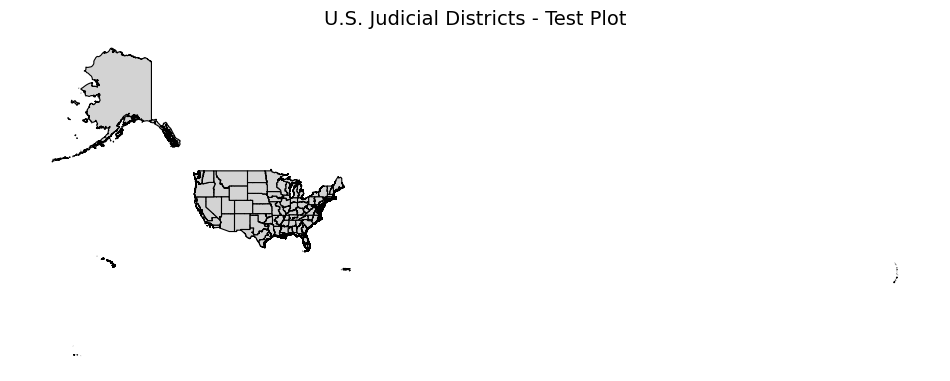

In [2298]:

# Plot to verify the shapefile
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.plot(ax=ax, color="lightgrey", edgecolor="black", linewidth=0.8)

# Customize
ax.set_title("U.S. Judicial Districts - Test Plot", fontsize=14)
ax.axis("off")  # Hide axis labels

plt.show()
